<a href="https://colab.research.google.com/github/dieko95/AlgoTrading/blob/master/Backtesting_only_test_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

#### Install Library

In [0]:
### Install bt package

!pip install bt
!pip install pydrive

     |████████████████████████████████| 2.7MB 2.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
     |████████████████████████████████| 993kB 3.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


### Authenticate Google 

In [0]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


W0618 18:09:37.909189 140519630833536 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Load Data from Drive 

In [0]:
import pandas as pd  

file_id = '1hA1Iq3N-T84Gq6xZm1WDhcycCxqay16Z'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

Return = pd.read_csv('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

W0618 18:09:39.077072 140519630833536 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

## Index as TimeStamp DateTime type 



In [0]:
Return.timeStamp = pd.to_datetime(Return.timeStamp) 
Return.set_index(Return["timeStamp"],inplace=True)

# Return = Return['predictedReturns']
Return.head()

,Unnamed: 0,timeStamp,predictedReturns
timeStamp,,,
2014-01-02,0,2014-01-02,-0.000896
2014-01-03,1,2014-01-03,0.010039
2014-01-04,2,2014-01-04,0.000000
2014-01-05,3,2014-01-05,0.000000
2014-01-06,4,2014-01-06,0.019169


In [0]:
# retOff = Return.index + pd.DateOffset(day=1)
returnOffset = Return.shift(1) # https://www.geeksforgeeks.org/python-pandas-dataframe-shift/
returnOffset.head()

,Unnamed: 0,timeStamp,predictedReturns
timeStamp,,,
2014-01-02,NaN,NaT,NaN
2014-01-03,0.0,2014-01-02,-0.000896
2014-01-04,1.0,2014-01-03,0.010039
2014-01-05,2.0,2014-01-04,0.000000
2014-01-06,3.0,2014-01-05,0.000000


## Creating the Strategy

In [0]:
# Creating Signal Variable
signal = Return['predictedReturns'] 
signal_offset = returnOffset['predictedReturns'] 
signal = pd.DataFrame(signal)
signal_offset = pd.DataFrame(signal_offset)
signal1 = signal.rename(columns={'predictedReturns':'rht_base'})
signal2 = signal.rename(columns={'predictedReturns':'rht_Strategy_2'})
signal3 = signal_offset.rename(columns={'predictedReturns':'rht_Strategy_3'})

# Creating Weights 
tw_1 = signal1.copy()
tw_2 = signal2.copy()
tw_3 = signal3.copy()

# Assign weight number for each type of signal strength
WeightStrongLong = 1.0
WeightMediumLong = 0.5
WeightWeak = 0
WeightMediumShort = -0.5
WeightStrongShort = -1.0


# Match the signal strength with the assigned weight
tw_1[signal1 > 0.02 ] = WeightStrongLong
tw_1[(signal1 >= 0.01) & (signal1 <= 0.02)] = WeightMediumLong
tw_1[(signal1 >= -0.01) & (signal1 <= 0.01)] = WeightWeak
tw_1[(signal1 <= -0.01) & (signal1 >= -0.02)] = WeightMediumShort
tw_1[signal1 < -0.02] = WeightStrongShort
tw_1[tw_1.isnull()] = 0 


# Do the same thing with signal2
tw_2[signal2 > 0.02 ] = WeightStrongLong
tw_2[(signal2 >= 0.01) & (signal2 <= 0.02)] = WeightMediumLong
tw_2[(signal2 >= -0.01) & (signal2 <= 0.01)] = WeightWeak
tw_2[(signal2 <= -0.01) & (signal2 >= -0.02)] = WeightMediumShort
tw_2[signal2 < -0.02] = WeightStrongShort
tw_2[tw_2.isnull()] = 0 


# Do the same thing with signal_offset
tw_3[signal3 > 0.02 ] = WeightStrongLong
tw_3[(signal3 >= 0.01) & (signal3 <= 0.02)] = WeightMediumLong
tw_3[(signal3 >= -0.01) & (signal3 <= 0.01)] = WeightWeak
tw_3[(signal3 <= -0.01) & (signal3 >= -0.02)] = WeightMediumShort
tw_3[signal3 < -0.02] = WeightStrongShort
tw_3[tw_3.isnull()] = 0 




In [0]:
%matplotlib inline


#import bt package
import bt

# fetch some data
data1 = bt.get( 'rht', start='2018-04-01', end= '2018-12-30')
data2 = bt.get( 'rht', start='2018-04-01', end= '2018-12-30')
data3 = bt.get( 'rht', start='2018-04-01', end= '2018-12-30')

data1 = data1.rename(columns={'rht':'rht_base'})
data2 = data2.rename(columns={'rht':'rht_Strategy_2'})
data3 = data3.rename(columns={'rht':'rht_Strategy_3'})



# # create the strategy
base = bt.Strategy('Base Strategy', [bt.algos.SelectWhere(signal1),
                        bt.algos.WeighTarget(tw_1),
                        bt.algos.Rebalance()])

s2 = bt.Strategy('LimitDeltas', [bt.algos.SelectWhere(signal2),
                        bt.algos.WeighTarget(tw_2),
                        bt.algos.LimitDeltas(), 
                        bt.algos.Rebalance()])

s3 = bt.Strategy('LimitDeltas & 1 day lag', [bt.algos.SelectWhere(signal3),
                        bt.algos.WeighTarget(tw_3),
                        bt.algos.LimitDeltas(), 
                        bt.algos.Rebalance()])



# Include Default comissions, we have realistic comissions

# s1.adjust(1000000,fee=0.1)
# # s1.commission_fn(getFee(10,5))

## Running Backtest

We should use: 

* Sharpe Ratio
* Sortino Ratio

Base Strategy
0% [############################# ] 100% | ETA: 00:00:00LimitDeltas
0% [############################# ] 100% | ETA: 00:00:00LimitDeltas & 1 day lag
0% [############################# ] 100% | ETA: 00:00:00Stat                 Base Strategy    LimitDeltas    LimitDeltas & 1 day lag
-------------------  ---------------  -------------  -------------------------
Start                2018-04-01       2018-04-01     2018-04-01
End                  2018-12-28       2018-12-28     2018-12-28
Risk-free rate       0.64%            0.64%          0.64%

Total Return         -46.85%          -8.62%         -1.46%
Daily Sharpe         -1.04            -0.54          -0.22
Daily Sortino        -1.10            -0.64          -0.31
CAGR                 -57.34%          -11.44%        -1.96%
Max Drawdown         -49.75%          -19.11%        -7.05%
Calmar Ratio         -1.15            -0.60          -0.28

MTD                  1.38%            2.01%          1.73%
3m                   

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


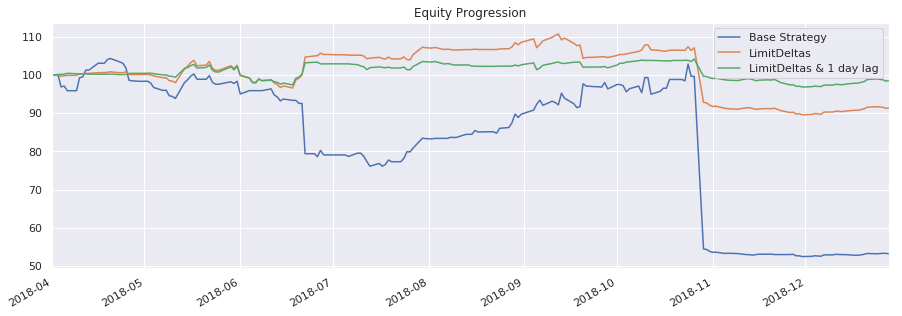

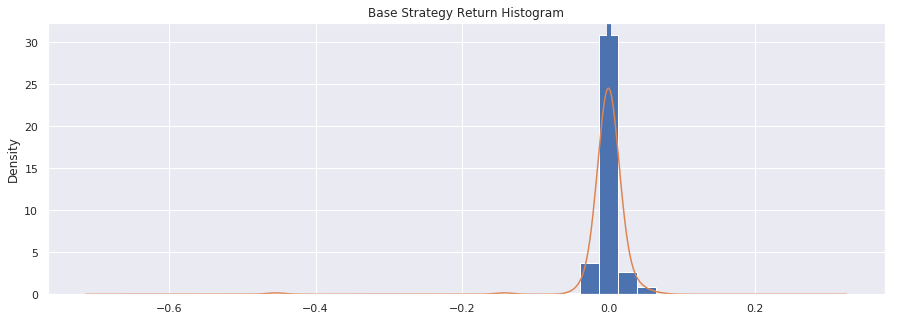

In [0]:
%matplotlib inline

import seaborn as sns
sns.set()


# We will need the risk-free rate to get correct Sharpe Ratios 
riskfree =  bt.get('^IRX', start= '2014-01-02', end= '2018-12-30')
# Take the average of the risk free rate over entire time period
riskfree_rate = float(riskfree.mean()) / 100 
# riskfree_rate = float(riskfree +1)^(1/250)+1


# create a backtest and run it
test1 = bt.Backtest(base, data1, commissions=lambda q, p: max(1, abs(q) * 0.01))
test2 = bt.Backtest(s2, data2, commissions=lambda q, p: max(1, abs(q) * 0.01))
test3 = bt.Backtest(s3, data3, commissions=lambda q, p: max(1, abs(q) * 0.01))

# res = bt.run(test3)
# res = bt.run(test1, test2)
res = bt.run(test1, test2, test3)

res.set_riskfree_rate(riskfree_rate)

# first let's see an equity curve
res.plot()

# ok and what about some stats?
res.display()

# ok and how does the return distribution look like?
res.plot_histogram()






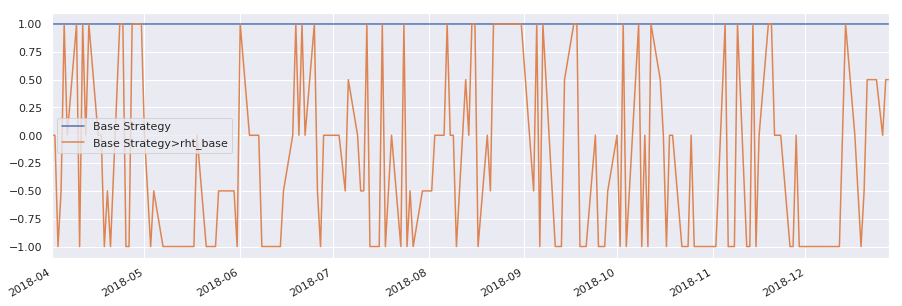

In [0]:
sns.set()
res.plot_weights() # Ask professor why there's a constant (blue line)

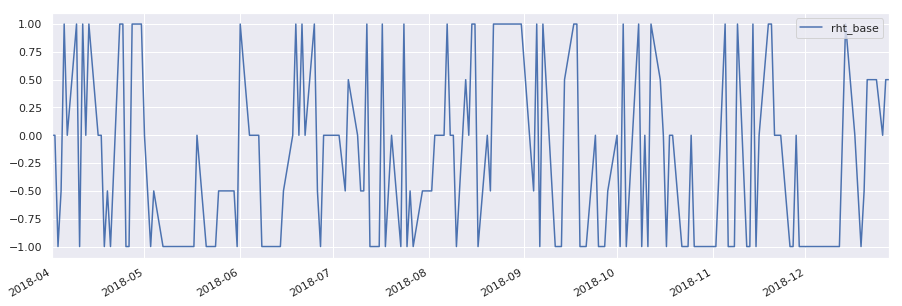

In [0]:
# and just to make sure everything went along as planned, let's plot the security weights over time
res.plot_security_weights()

In [0]:
res.display_lookback_returns()


## Getting Transactions per Day

In [0]:

# Get Transactions
import seaborn as sns
trans = res.get_transactions()
trans

In [0]:
# ret = res.display_monthly_returns()
# trans..plot()

res.display_monthly_returns(0)

## Strategy with Benchmark

In [0]:
import matplotlib.pyplot as plt

sns.set()
# sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")
  
# benchmark = long_only_ew('spy', name='spy')






#data['predictedReturns'] = Return['predictedReturns']


# signal = Return['predictedReturns'] #> 0.01

# signal = pd.DataFrame(signal)
# signal = signal.rename(columns={'predictedReturns':'rht'})

# We will need the risk-free rate to get correct Sharpe Ratios 
riskfree =  bt.get('^IRX', start= '2014-01-02', end= '2018-12-30')

# Take the average of the risk free rate over entire time period
riskfree_rate = float(riskfree.mean()) / 100 


dataBench = bt.get( 'spy', start='2014-01-02', end= '2018-12-30')


# # create the strategy
sBench = bt.Strategy('spyBench', [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

testBench = bt.Backtest(sBench, dataBench, commissions=lambda q, p: max(1, abs(q) * 0.01))


res2 = bt.run(testBench,test)
res2.display()
res2.plot()
# res2.weights()


In [0]:
tw_1